In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-04 11:56:01.149078: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 11:56:01.149230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 11:56:01.294326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Selectia datelor

o alegere intre 2 seturi de date: 
1 - setul cervical-cancer-balanced-dataset ; 2 - set cu rezolutia de 64x64 creat de Radu si Ioana Dogaru utilizand cod adaptat dupa https://www.kaggle.com/code/prakharpipersania/cervical-cancer setul de date 2 atasat este partajat de Ioana Dogaru (nu este public) https://www.kaggle.com/datasets/ioanad70/cerv64 s-au efectuat o serie de prelucrari pe imaginile decupate (vezi in cod original)

In [39]:
datagen=True # forma de acces la date 
myset=2


if myset==1:
    dataset='cerv64' # pentru listarea intr-un raport 

    train_dir='/kaggle/input/cerv64/cerv64_propriu/train'
    val_dir='/kaggle/input/cerv64/cerv64_propriu/val'
    test_dir='/kaggle/input/cerv64/cerv64_propriu/test'
    
    train_datagen = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True)
    val_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen = ImageDataGenerator(rescale = 1./255)

    imsize = 96
    batch_size = 16 #de testat optimul
    train_batch = batch_size 
    val_batch = batch_size 
    test_batch = batch_size

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(imsize, imsize), batch_size = train_batch)
    validation_generator = val_datagen.flow_from_directory(val_dir, target_size=(imsize, imsize), batch_size = val_batch)
    test_generator = test_datagen.flow_from_directory(test_dir, target_size=(imsize, imsize), batch_size = batch_size, class_mode = 'categorical')

elif myset==2:
    dataset='cervical_cancer2' # pentru listarea intr-un raport 

    train_dir='/kaggle/input/cervical-cancer-balanced-dataset/Cervical Cancer Balanced Data/train'
    val_dir='/kaggle/input/cervical-cancer-balanced-dataset/Cervical Cancer Balanced Data/val'
    test_dir='/kaggle/input/cervical-cancer-balanced-dataset/Cervical Cancer Balanced Data/test'

    train_datagen = ImageDataGenerator(rescale = 1./255)
    val_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen = ImageDataGenerator(rescale = 1./255)

    imsize = 96
    batch_size = 16
    train_batch = batch_size 
    val_batch = batch_size 
    test_batch = batch_size

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(imsize, imsize), batch_size = train_batch)
    validation_generator = val_datagen.flow_from_directory(val_dir, target_size=(imsize, imsize), batch_size = val_batch)
    test_generator = test_datagen.flow_from_directory(test_dir, target_size=(imsize, imsize), batch_size = batch_size, class_mode = 'categorical')
    
classes = list(train_generator.class_indices.keys())
classes


input_shape = train_generator.image_shape
num_classes = len(classes)
                            
                                    
print('numar clase: ', num_classes)
print('format intrare: ', input_shape)
print('etichetele claselor: ', classes)


Found 7659 images belonging to 3 classes.
Found 2411 images belonging to 3 classes.
Found 1804 images belonging to 3 classes.
numar clase:  3
format intrare:  (96, 96, 3)
etichetele claselor:  ['Type_1', 'Type_2', 'Type_3']


# V-CNN MODEL

In [41]:
# V-CNN Versatile CNN model -
# includes L-CNN, NL-CNN and XNL-CNN as particular cases.
# The basic unit is the "macro-layer" as in the XNL-CNN but here one can independently choose the
# filter size (fil) and
# nonlinearity nl (0 means "linear" convolution)
# It allows any number of additional dense layers e.g. hid=[] (no hidden dense) or hid =[100, 100] (two additional).
# Copyright Radu and Ioana DOGARU - correspondence: radu.dogaru@upb.ro
# Last update June 21, 2023
# Code located at https://colab.research.google.com/github/radu-dogaru/V-CNN/
#-------------------------------------------------------------------------------------------------

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D  # straturi convolutionale si max-pooling
from tensorflow.keras.optimizers import RMSprop, SGD, Adadelta, Adam, Nadam

In [42]:
def create_v_cnn_model(input_shape, num_classes, flat=1, fil=[100,100,100,100], nl=[1,1,0,0], hid=[]):
    # Note the number of elements in fil list (macrolayers) should be the same in nl list
    # hid can be [] while if the are elements, additional dense layers are added in the output classifier

    csize=3; stri=2; psiz=4; pad='same';
    drop1=0.6  # Best value for CIFAR-100 after tuning in range 0.25 - 0.75 !

    nfilmax=np.shape(np.array(fil))[0]
    model = Sequential()
    # First macrolayer - connected to input  ----------------
    layer=0
    if nl[layer]>0:
        model.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize), input_shape=input_shape ) )
        model.add(Activation('relu'))
        for nonlin in range(1,nl[0]):
            model.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize)) )
            model.add(Activation('relu'))

        model.add(Conv2D(fil[0], padding=pad, kernel_size=(csize, csize) ) )
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad))
        model.add(Dropout(drop1))

    else:
        model.add(Conv2D(fil[0], padding=pad, kernel_size=(csize, csize), input_shape=input_shape ) )
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad))
        model.add(Dropout(drop1))
    # The remaining  macro-layers

    for layer in range(1,nfilmax):
        #------------------ nonlin layers -----------------
        for nonlin in range(nl[layer]):
            model.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize)) )
            model.add(Activation('relu'))

        #----------------- default macrolayer output

        model.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize)) )
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad))
        model.add(Dropout(drop1))

    # Exit classifier
    # INPUT TO DENSE LAYER (FLATTEN - more data can overfit / GLOBAL - less data - may be a good choice )
    if flat==1:
        model.add(Flatten())  # alternanta cu GlobalAv ..
    elif flat==0:
        model.add(GlobalAveragePooling2D()) # pare sa fie mai Ok la cifar
    nhid=np.shape(np.array(hid))[0]
    if nhid>0:
        for lay in range(nhid):
            model.add(Dense(hid[lay], activation='relu'))
            #model.add(Dropout(drop1))
    model.add(Dense(num_classes, activation='softmax'))

# END OF MODEL DESCRIPTION
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## Instantiere model V-CNN

In [43]:
myflat=0; myfil=[40,80,140,40]; mynl=[2,1,1,1,0]; myhid=[]   # aici se pot testa diferite alte valori 
model=create_v_cnn_model(input_shape, num_classes, flat=myflat, fil=myfil, nl=mynl, hid=myhid)
model_name='VCNN_'+str(myflat)+'_'+str(myfil)+'_'+str(mynl)+'_'+str(myhid)
print(model_name)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


VCNN_0_[40, 80, 140, 40]_[2, 1, 1, 1, 0]_[]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 40)     │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 96, 96, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 96, 96, 40)     │        14,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 96, 96, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 96, 96, 40)     │        14,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 96, 96, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 48, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 80)     │        28,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 48, 48, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 80)     │        57,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 80)     │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 140)    │       100,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 24, 24, 140)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 140)    │       176,540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 140)    │           560 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 140)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 140)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 40)     │        50,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 12, 12, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 40)     │        14,440 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 460,243 (1.76 MB)

 Trainable params: 459,643 (1.75 MB)

 Non-trainable params: 600 (2.34 KB)

# NL-CNN MODEL

In [3]:
# Returns a precompiled model with a specific optimizer included 
#==============================================================================================
from tensorflow.keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers  import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D  # straturi convolutionale si max-pooling 
from tensorflow.keras.optimizers import  SGD, Adadelta, Adam, Nadam


def create_nl_cnn_model(input_shape, num_classes, k=1.5,separ=0, flat=0, width=80, nl=(3,2), add_layer=0):
  # Arguments: k - multiplication coefficient 
  # Structure parameteres 
  kfil=k
  filtre1=width ; filtre2=int(kfil*filtre1) ; filtre3=(kfil*filtre2)  # filters (kernels) per each layer - efic. pe primul 
  nr_conv=3 # 0, 1, 2 sau 3  (number of convolution layers)
  csize1=3; csize2=3 ; csize3=3      # convolution kernel size (square kernel) 
  psize1=4; psize2=4 ; psize3=4      # pooling size (square)
  str1=2; str2=2; str3=2             # stride pooling (downsampling rate) 
  pad='same'; # padding style ('valid' is also an alternative)
  nonlinlayers1=nl[0]  # total of layers (with RELU nonlin) in the first maxpool layer  # De parametrizat asta 
  nonlinlayers2=nl[1]  # 

  nonlin_type='relu' # may be other as well 'tanh' 'elu' 'softsign'
  bndrop=1 # include BatchNorm inainte de MaxPool si drop(0.3) dupa .. 
  cvdrop=1 # droput 
  drop_cv=0.5
  
  model = Sequential()
  # convolution layer1  ==========================================================================
  # Initially first layer was always a Conv2D one
  if separ==1:
    model.add( SeparableConv2D(filtre1, padding=pad, kernel_size=(csize1, csize1), input_shape=input_shape) )
  elif separ==0: 
    model.add( Conv2D(filtre1, padding=pad, kernel_size=(csize1, csize1), input_shape=input_shape) )

  # next are the additional layers 
  for nl in range(nonlinlayers1-1):
    model.add(Activation(nonlin_type))  # Activ NL-CNN-1
    if separ==1:
      model.add(SeparableConv2D(filtre1, padding=pad, kernel_size=(csize1, csize1) ) ) # Activ NL-CNN-2
    elif separ==0:
      model.add(Conv2D(filtre1, padding=pad, kernel_size=(csize1, csize1)) ) # Activ NL-CNN-2
  #  MaxPool in the end of the module 
  if bndrop==1:
    model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(psize1, psize1),strides=(str1,str1),padding=pad))
  if cvdrop==1:
    model.add(Dropout(drop_cv))
  
  # NL LAYER 2 =======================================================================================================
 
  if separ==1:
    model.add(SeparableConv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) )
  elif separ==0:
    model.add(Conv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) )
  # aici se adauga un neliniar 
    
  #=========== unul extra NL=2 pe strat 2 =====================
  for nl in range(nonlinlayers2-1):
    model.add(Activation(nonlin_type))  # Activ NL-CNN-1
    if separ==1:
        model.add(SeparableConv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) ) # Activ NL-CNN-2
    elif separ==0:
        model.add(Conv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) ) # Activ NL-CNN-2
        
  # OUTPUT OF LAYER 2 (MAX-POOL)
  if bndrop==1:
      model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(psize2, psize2),strides=(str2,str2),padding=pad))
  if cvdrop==1:
      model.add(Dropout(drop_cv))
  #-------------------------------------------------------------------------------------------
  # LAYER 3 
      
  if separ==1:
      model.add(SeparableConv2D(filtre3, padding=pad, kernel_size=(csize3, csize3)) )  # SeparableConv
  elif separ==0:
      model.add(Conv2D(filtre3, padding=pad, kernel_size=(csize3, csize3)) ) # Activ NL-CNN-2
  # OUTPUT OF LAYER 3 
  if bndrop==1:
      model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(psize3, psize3),strides=(str3,str3),padding=pad))
  if cvdrop==1:
      model.add(Dropout(drop_cv))
  #------------------- 
  # 
  # LAYER 4  (only if requested - for large images ?? )
  if add_layer==1:    
    if separ==1:
      model.add(SeparableConv2D(1.2*filtre3, padding=pad, kernel_size=(csize3, csize3)) )  # SeparableConv
    elif separ==0:
      model.add(Conv2D(1.2*filtre3, padding=pad, kernel_size=(csize3, csize3)) ) # Activ NL-CNN-2
    # OUTPUT OF LAYER 4
    if bndrop==1:
      model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(psize3, psize3),strides=(str3,str3),padding=pad))
    if cvdrop==1:
      model.add(Dropout(drop_cv))
  #========================================================================================
  # INPUT TO DENSE LAYER (FLATTEN - more data can overfit / GLOBAL - less data - may be a good choice ) 
  if flat==1:
      model.add(Flatten())  # 
  elif flat==0:
      model.add(GlobalAveragePooling2D()) # Global average 
   
  model.add(Dense(num_classes, activation='softmax'))
  # END OF MODEL DESCRIPTION 
  # ------------------ COMPILE THE MODEL
  myopt = Adam()
  #myopt = Nadam()
  if separ==1:
    myopt = RMSprop(lr=0.01) 
    #myopt = Adam(lr=0.05)

  # --------------------------   LOSS function  ------------------------------------
  my_loss='categorical_crossentropy'
  model.compile(loss=my_loss, 
              optimizer=myopt,   
              metrics=['accuracy'])

  return model

## Instantiere model NL-CNN

In [4]:
k=2; separ=0; flat=1; width=40; nl=(2,2)
model = create_nl_cnn_model(input_shape, num_classes, k, separ, flat, width, nl, add_layer=0)
model_name='NLCNN_'+str(k)+'_'+str(separ)+'_'+str(flat)+'_'+str(width)+'_'+str(nl)
print(model_name)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


NLCNN_2_0_1_40_(2, 2)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 40)     │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 96, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 40)     │        14,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 80)     │        28,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 80)     │        57,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 80)     │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 160)    │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 160)    │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23040)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        69,123 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,723 (1.10 MB)

 Trainable params: 287,163 (1.10 MB)

 Non-trainable params: 560 (2.19 KB)

# MobileNETV2 MODEL

In [40]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Activation, Input

def create_model():
    pretrained_model = tf.keras.applications.MobileNetV2(alpha=0.35, weights='imagenet', include_top=False ,input_shape=[imsize, imsize, 3])
    pretrained_model.trainable = True # tramsfer learning
    
    model = tf.keras.Sequential([
        pretrained_model,
        GlobalAveragePooling2D(),
        Dense(num_classes, activation='softmax')
    ])
    model.build()
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
     )
    return model

model = create_model()
model_name = 'MobileNetV2'
print(model_name)
model.summary()

MobileNetV2


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.35_96             │ ?                      │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410,208 (1.56 MB)

 Trainable params: 396,128 (1.51 MB)

 Non-trainable params: 14,080 (55.00 KB)

# ANTRENARE MODELE

In [41]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import time as ti
checkpoint = ModelCheckpoint('best_model.keras', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose=1)

In [42]:
epoci=100

t1=ti.time()
if datagen:
  history = model.fit(train_generator, epochs=epoci, validation_data=validation_generator, verbose=1, 
                    callbacks = checkpoint)
else: 
  history = model.fit(x_train, y_train, epochs=epoci, validation_data=(x_test, y_test), batch_size=batch_size, verbose=1,
                    callbacks = checkpoint)
    
t2=ti.time()
print('====================================================')
print('Training with  ',epoci,' epochs, lasted  ',int(t2-t1)/60,' minutes')

model=load_model('best_model.keras')
print(model.name)
bp=model.get_weights()  # best weights set
t1=ti.time()
if datagen:
    score = model.evaluate(validation_generator, verbose=0)
else:
    score = model.evaluate(x_test, y_test, verbose=0)
t2=ti.time()

print('--------------  Raport rulare ------------------------')
print ('Marime model (parametri): ',model.count_params())
print('Cea mai buna acuratete pe set validare :', 100*score[1],'%')
print ('Timp predictie pe tot setul de test: ',t2-t1)
print('Set date: ',dataset)
print('Model: ',model_name)
print('Dimensiune imagine: ',imsize)
print('Batch size: ', batch_size)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5687 - loss: 0.9880
Epoch 1: val_accuracy improved from -inf to 0.44421, saving model to best_model.keras
479/479 ━━━━━━━━━━━━━━━━━━━━ 121s 163ms/step - accuracy: 0.5689 - loss: 0.9875 - val_accuracy: 0.4442 - val_loss: 1.3871
Epoch 2/100
477/479 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6950 - loss: 0.6611
Epoch 2: val_accuracy did not improve from 0.44421
479/479 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.6950 - loss: 0.6611 - val_accuracy: 0.3716 - val_loss: 3.3308
Epoch 3/100
477/479 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7261 - loss: 0.5994
Epoch 3: val_accuracy improved from 0.44421 to 0.55827, saving model to best_model.keras
479/479 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.7261 - loss: 0.5994 - val_accuracy: 0.5583 - val_loss: 1.7543
Epoch 4/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7465 - loss: 0.5422
Epoch 4: val_accuracy did not improve from 0.55827
479/479 ━━━━━━━━━━━━━━━

In [7]:
import os

# Salvare model V-CNN

In [47]:
file_name = 'best_model.keras'
#new_name = f"VCNN_model__{int(score[1] * 10000)}.keras"
new_name = f"Set2_VCNN_model__{int(score[1] * 10000)}.keras"
os.rename(file_name, new_name)


# Salvare model NL-CNN

In [16]:
file_name = 'best_model.keras'
#new_name = f"NLCNN_model__{int(score[1] * 10000)}.keras"
new_name = f"Set2_NLCNN_model__{int(score[1] * 10000)}.keras"
os.rename(file_name, new_name)

FileNotFoundError: [Errno 2] No such file or directory: 'Set2_VCNN_model__5599.keras' -> 'Set2_NLCNN_model__5599.keras'

# Salvare model MobileNetV2

In [43]:
file_name = 'best_model.keras'
#new_name = f"MobileNetV2_model__{int(score[1] * 10000)}.keras"
new_name = f"Set2_MobileNetV2_model__{int(score[1] * 10000)}.keras"
os.rename(file_name, new_name)

# Reprezentare grafica

/tmp/ipykernel_35/1987551810.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


Model:  MobileNetV2


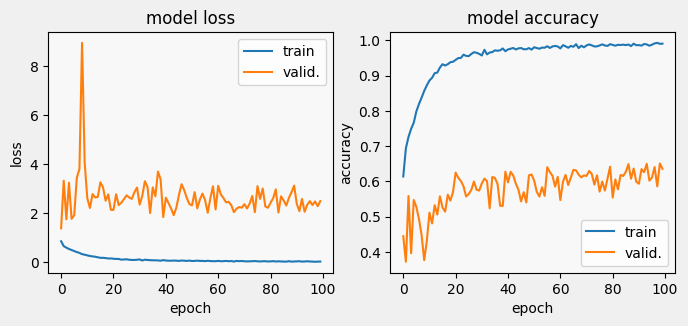

In [44]:
from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(7,3), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 122)

print('Model: ',model_name)

# Matricea de confuzie

In [46]:
# Loading the Lowest validation loss Model 
#model = load_model('VCNN_model__9095.keras')
#model = load_model('Set2_VCNN_model__6445.keras')
#model = load_model('NLCNN_model__9046.keras')
#model = load_model('Set2_NLCNN_model__5599.keras')
#model = load_model('MobileNetV2_model__9539.keras')
model = load_model('Set2_MobileNetV2_model__6503.keras')


# redefinire batch_size=intregul pachet de date (609 aici) deaorece altfel
# matricea de confuzie s-ar calcula numai pe un pachet "batch_size =16" si este irelevanta
test_generator.reset()
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(imsize, imsize), batch_size = 1804, class_mode = 'categorical')

#val_data.reset()
t1=ti.time()
accuracy = model.evaluate(test_generator, batch_size=609)[1] 
t2=ti.time()
print(f"Acuratete set test = {accuracy*100} %")
print ('Martime model (parametri): ',model.count_params())
print('Latenta per intreg set test: ', 1000*(t2-t1), 'mili seconds')
print('Latenta per sample: ', 1000*(t2-t1)/(609), 'mili seconds')

#-- matrice de confuzie -------------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix
# leucreaza pe un pachet de dimensiune batch_size 
# eventual ar trebui redefint setul de test 


for i,j in test_generator:
    print(i.shape, j.shape)
    p = model.predict(i)
    p = p.argmax(-1)
    t = j.argmax(-1)
    print(classification_report(t,p))
    print(confusion_matrix(t,p))
    break

Found 1804 images belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.5527 - loss: 2.6074
Acuratete set test = 55.26607632637024 %
Martime model (parametri):  414051
Latenta per intreg set test:  26004.853010177612 mili seconds
Latenta per sample:  42.70090806268902 mili seconds
(1804, 96, 96, 3) (1804, 3)
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step
              precision    recall  f1-score   support

           0       0.50      0.58      0.54       199
           1       0.64      0.56      0.60       997
           2       0.46      0.53      0.49       608

    accuracy                           0.55      1804
   macro avg       0.53      0.56      0.54      1804
weighted avg       0.56      0.55      0.56      1804

[[116  47  36]
 [ 95 559 343]
 [ 21 265 322]]


# Testare

pt. VCNN si NLCNN nu merge momentan, nu mi se prezice corect nicio imagine - clasa prezisa este aproape mereu Dyskeratotic

In [47]:
 test_generator = test_datagen.flow_from_directory(test_dir, target_size=(imsize, imsize), batch_size = 1, class_mode = 'categorical')

Found 1804 images belonging to 3 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Eticheta reală: Type_2
Eticheta prezisă: Type_3


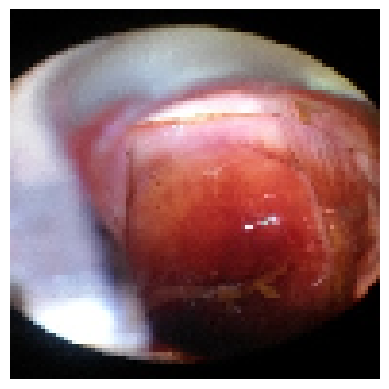

In [53]:
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Assuming you have functions to load your test data generator (`test_generator`) and class labels (`classes`)

# Load the saved model
#model_path = "VCNN_model__9095.keras"
#model_path = "Set2_VCNN_model__6445.keras"
#model_path = "NLCNN_model__9046.keras"
#model_path = "Set2_NLCNN_model__5599.keras"
#model_path = "MobileNetV2_model__9539.keras"
model_path = "Set2_MobileNetV2_model__6503.keras"
model = load_model(model_path)

# Select a random image from the test set (assuming `test_generator` provides images and labels)
random_index = random.randint(0, len(test_generator) - 1)
test_image, test_label = test_generator[random_index][0][0], test_generator[random_index][1][0]

# Expand dimension (likely for compatibility with the model's expected input shape)
test_image = np.expand_dims(test_image, axis=0)

# Predict the label for the selected image
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability

# Display the image (optional)
plt.imshow(test_image[0])
plt.axis('off')

# Get the real label based on the index in `test_label`
real_label = classes[np.argmax(test_label)]

# Print the real and predicted labels
print("Eticheta reală:", real_label)
print("Eticheta prezisă:", classes[predicted_class])

# Display the image (optional)
plt.show()
